In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
from dival.datasets import get_standard_dataset
from dival.reference_reconstructors import get_reference_reconstructor
from torchmetrics.functional import structural_similarity_index_measure as ssim
import os

In [2]:
dataset = get_standard_dataset("lodopab", impl="astra_cpu")

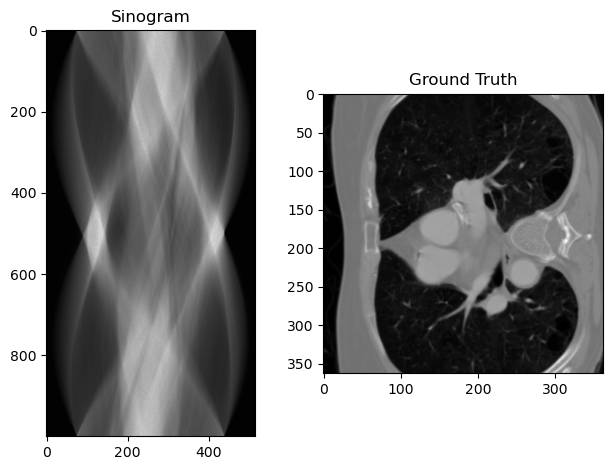

In [3]:
sinogram, ground_truth = dataset.get_sample(0, part="train")

def normalize(x):
    x = x.astype(np.float32)
    return (x - x.min()) / (x.max() - x.min())

plt.subplot(1, 2, 1)
plt.imshow(normalize(sinogram.data), cmap="gray")
plt.title("Sinogram")

plt.subplot(1, 2, 2)
plt.imshow(normalize(ground_truth.data), cmap="gray")
plt.title("Ground Truth")
plt.tight_layout()
plt.show()

In [4]:
fbp = get_reference_reconstructor('fbp', 'lodopab', impl='astra_cpu')

class CTDataset(Dataset):
    def __init__(self, dival_dataset, part='train', n_samples=1000):
        self.samples = [dival_dataset.get_sample(i, part=part) for i in range(n_samples)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sino, gt = self.samples[idx]
        recon = fbp.reconstruct(sino.data)

        recon = normalize(recon.data)
        gt = normalize(gt.data)
        return (
            torch.tensor(recon)[None, :, :],  # [1, H, W]
            torch.tensor(gt)[None, :, :]
        )

train_set = CTDataset(dataset, part='train', n_samples=1000)
test_set = CTDataset(dataset, part='test', n_samples=100)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16)

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 5, padding=2), nn.ReLU(),
            nn.Conv2d(64, 64, 5, padding=2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(),
            nn.Conv2d(128, 128, 5, padding=2), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, 5, padding=2), nn.ReLU(),
            nn.Conv2d(64, 1, 5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def combined_loss(pred, target, alpha=0.8):
    """
    alpha: weight on SSIM (set closer to 1 for more perceptual sharpness)
    """
    ssim_val = ssim(pred, target, data_range=1.0)
    mse_val = nn.functional.mse_loss(pred, target)
    return alpha * (1 - ssim_val) + (1 - alpha) * mse_val

In [7]:
for epoch in range(10):
    model.train()
    total_loss = 0
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = combined_loss(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

  0%|          | 0/63 [00:00<?, ?it/s]/opt/anaconda3/envs/numpy/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
100%|██████████| 63/63 [51:08<00:00, 48.70s/it]


Epoch 1, Loss: 0.2726


100%|██████████| 63/63 [50:36<00:00, 48.21s/it]


Epoch 2, Loss: 0.1892


100%|██████████| 63/63 [50:33<00:00, 48.15s/it]


Epoch 3, Loss: 0.1707


100%|██████████| 63/63 [1:00:13<00:00, 57.36s/it]


Epoch 4, Loss: 0.1624


100%|██████████| 63/63 [50:24<00:00, 48.01s/it]


Epoch 5, Loss: 0.1601


100%|██████████| 63/63 [50:38<00:00, 48.23s/it]


Epoch 6, Loss: 0.1603


100%|██████████| 63/63 [50:42<00:00, 48.29s/it]


Epoch 7, Loss: 0.1526


100%|██████████| 63/63 [50:34<00:00, 48.17s/it]


Epoch 8, Loss: 0.1587


100%|██████████| 63/63 [50:31<00:00, 48.13s/it]


Epoch 9, Loss: 0.1479


100%|██████████| 63/63 [50:25<00:00, 48.02s/it]

Epoch 10, Loss: 0.1482


In [10]:
# Save entire model + optimizer state (for resuming training or inference)
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
if not os.path.exists("fbp_checkpoints"):
    os.makedirs("fbp_checkpoints")
path = "fbp_checkpoints/fbp_lodopab.pth"
torch.save(checkpoint, path)
print("Model saved to ", path)

Model saved to  fbp_checkpoints/fbp_lodopab.pth


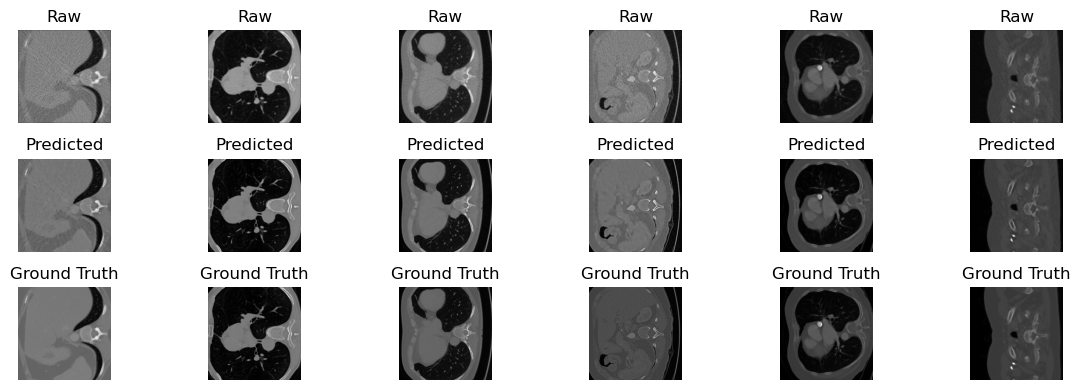

In [8]:
model.eval()
with torch.no_grad():
    for sino, gt in test_loader:
        sino, gt = sino.to(device), gt.to(device)
        pred = model(sino)
        break

sino = sino.cpu().numpy()
pred = pred.cpu().numpy()
gt = gt.cpu().numpy()

plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(3, 6, i + 1)
    plt.imshow(normalize(sino[i][0]), cmap="gray")
    plt.title("Raw")
    plt.axis('off')

    plt.subplot(3, 6, i + 7)
    plt.imshow(normalize(pred[i][0]), cmap="gray")
    plt.title("Predicted")
    plt.axis('off')

    plt.subplot(3, 6, i + 13)
    plt.imshow(normalize(gt[i][0]), cmap="gray")
    plt.title("Ground Truth")
    plt.axis('off')
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/numpy/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(


Mean SSIM (Raw): 0.650828838348
Mean SSIM (Predicted): 0.801550040022
Mean PSNR (Raw): 23.9438716173
Mean PSNR (Predicted): 30.6137108803


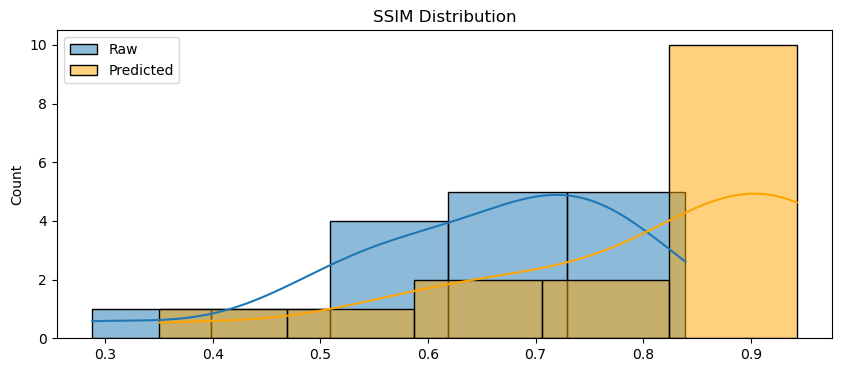

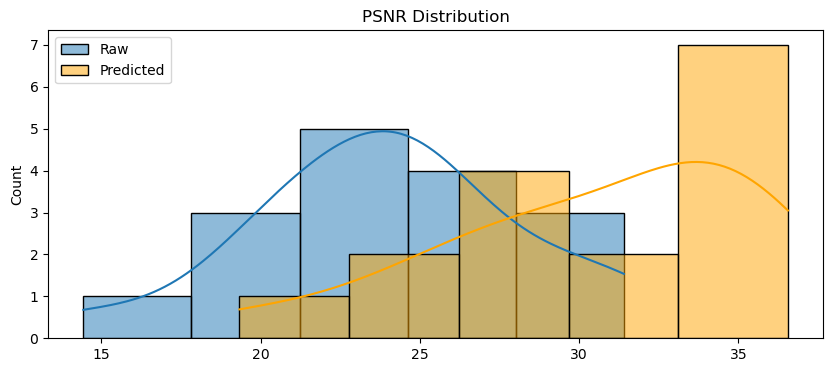

In [12]:
from torchmetrics.functional import peak_signal_noise_ratio as psnr
import seaborn as sns

# Ensure we're working with torch tensors in [0,1]
sino_tensor = torch.tensor(sino)
pred_tensor = torch.tensor(pred)
gt_tensor = torch.tensor(gt)

# Initialize lists
ssim_raw, psnr_raw = [], []
ssim_pred, psnr_pred = [], []

for i in range(len(gt_tensor)):
    raw_img = sino_tensor[i]
    pred_img = pred_tensor[i]
    gt_img = gt_tensor[i]

    ssim_raw.append(ssim(raw_img.unsqueeze(0), gt_img.unsqueeze(0), data_range=1.0).item())
    psnr_raw.append(psnr(raw_img.unsqueeze(0), gt_img.unsqueeze(0), data_range=1.0).item())

    ssim_pred.append(ssim(pred_img.unsqueeze(0), gt_img.unsqueeze(0), data_range=1.0).item())
    psnr_pred.append(psnr(pred_img.unsqueeze(0), gt_img.unsqueeze(0), data_range=1.0).item())

print("Mean SSIM (Raw):", np.mean(ssim_raw))
print("Mean SSIM (Predicted):", np.mean(ssim_pred))
print("Mean PSNR (Raw):", np.mean(psnr_raw))
print("Mean PSNR (Predicted):", np.mean(psnr_pred))

# Optional: plot distributions
plt.figure(figsize=(10, 4))
sns.histplot(ssim_raw, label='Raw', kde=True)
sns.histplot(ssim_pred, label='Predicted', kde=True, color='orange')
plt.legend(); plt.title("SSIM Distribution"); plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(psnr_raw, label='Raw', kde=True)
sns.histplot(psnr_pred, label='Predicted', kde=True, color='orange')
plt.legend(); plt.title("PSNR Distribution"); plt.show()

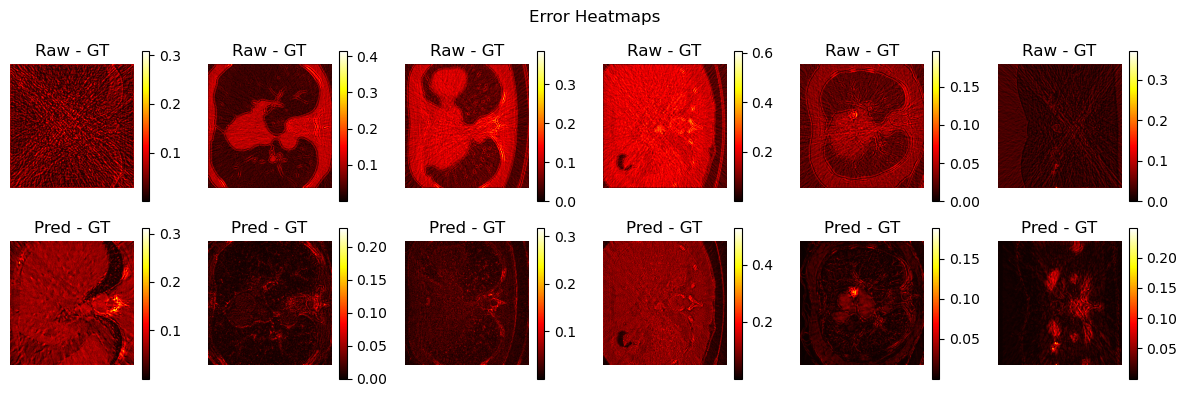

In [16]:
# Difference heatmap for visual comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
for i in range(6):
    diff_pred = np.abs(pred[i][0] - gt[i][0])
    diff_raw = np.abs(sino[i][0] - gt[i][0])

    plt.subplot(2, 6, i + 1)
    plt.imshow(diff_raw, cmap='hot')
    plt.title("Raw - GT")
    plt.axis("off")

    # Add colorbar
    plt.colorbar()

    plt.subplot(2, 6, i + 7)
    plt.imshow(diff_pred, cmap='hot')
    plt.title("Pred - GT")
    plt.axis("off")

    # Add colorbar
    plt.colorbar()

plt.suptitle("Error Heatmaps")
plt.tight_layout()
plt.show()